In [1]:
import pandas as pd
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
import geopandas as gpd
import matplotlib as mpl
import folium
from matplotlib.colors import LogNorm
import geopandas as gpd

In [2]:
df = pd.read_csv('geo_routes.csv')
df.columns = df.columns.str.strip()

G = nx.DiGraph()


unfound_airport_codes = set()

for index, row in df.iterrows():
    source_airport = row['source airport']
    destination_airport = row['destination apirport']  # for some reason `destination airport` is spelled wrong in the spreadsheet
    airline_code = row['airline']
    num_stops = row['stops']
    # equipment_used = row['equipment']

    airline = row['Airline Name']
    alliance = row['Flight Alliance']

    src_lat = row['lat_src']
    src_lng = row['lng_src']
    src_elev = row['elevation_src']

    dest_lat = row['lat_dest']
    dest_lng = row['lng_dest']
    dest_elev = row['elevation_dest']

    


    # I wanted to add equipment but it seems that b/c the equipment_used row is full of different types of data values
    # it can't be imported into Gephi

    
    # add nodes for the airports if they are not already in the graph
    
    
    
    if row['source airport'] not in G:
        G.add_node(source_airport, airline = airline_code, stops = num_stops, latitude=src_lat, longitude=src_lng, elevation=src_elev)
    if row['destination apirport'] not in G:
        G.add_node(destination_airport, airline = airline_code, stops = num_stops, latitude=dest_lat, longitude=dest_lng, elevation=dest_elev)
    
    # add a directed edge from source to destination
    G.add_edge(source_airport, destination_airport, airline_name=airline, flight_alliance=alliance)






nx.write_graphml(G, "network.graphml")

In [3]:
# basic statistics
N = len(G)
L = G.size()
degrees = [G.degree(node) for node in G]
kmin = min(degrees)
kmax = max(degrees)

print("Number of nodes: ", N)
print("Number of edges: ", L)
print()
print("Average degree: ", 2*L/N)
print("Average degree (alternate calculation)", np.mean(degrees))
print()
print("Minimum degree: ", kmin)
print("Maximum degree: ", kmax)

Number of nodes:  3425
Number of edges:  37595

Average degree:  21.953284671532845
Average degree (alternate calculation) 21.953284671532845

Minimum degree:  1
Maximum degree:  477


In [4]:
# find number of strongly and weakly connected components
num_strongly_connected = nx.number_strongly_connected_components(G)
num_weakly_connected = nx.number_weakly_connected_components(G)

# find largest strongly and weakly connected components
largest_strongly_connected = max(nx.strongly_connected_components(G), key=len)
largest_weakly_connected = max(nx.weakly_connected_components(G), key=len)

print("Number of strongly connected components:", num_strongly_connected)
print("Number of weakly connected components:", num_weakly_connected)
print("Size of the largest strongly connected component:", len(largest_strongly_connected))
print("Size of the largest weakly connected component:", len(largest_weakly_connected))


Number of strongly connected components: 44
Number of weakly connected components: 8
Size of the largest strongly connected component: 3354
Size of the largest weakly connected component: 3397


In [5]:
density = nx.density(G)
print("Network density:", density)


Network density: 0.003205795074698138


In [6]:
# idk if i even doing this right, just some stastic that looked interesting.
avg_clustering = nx.average_clustering(G.to_undirected())
print("Average clustering coefficient:", avg_clustering)


Average clustering coefficient: 0.4870933566129556


Log Scale Degree Distribution

In [7]:

%matplotlib inline
mpl.rc('xtick', labelsize=14, color="#222222") 
mpl.rc('ytick', labelsize=14, color="#222222") 
mpl.rc('font', **{'family':'sans-serif','sans-serif':['Arial']})
mpl.rc('font', size=16)
mpl.rc('xtick.major', size=6, width=1)
mpl.rc('xtick.minor', size=3, width=1)
mpl.rc('ytick.major', size=6, width=1)
mpl.rc('ytick.minor', size=3, width=1)
mpl.rc('axes', linewidth=1, edgecolor="#222222", labelcolor="#222222")
mpl.rc('text', usetex=False, color="#222222")

In [8]:
# Get 10 logarithmically spaced bins between kmin and kmax
bin_edges = np.logspace(np.log10(kmin), np.log10(kmax), num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

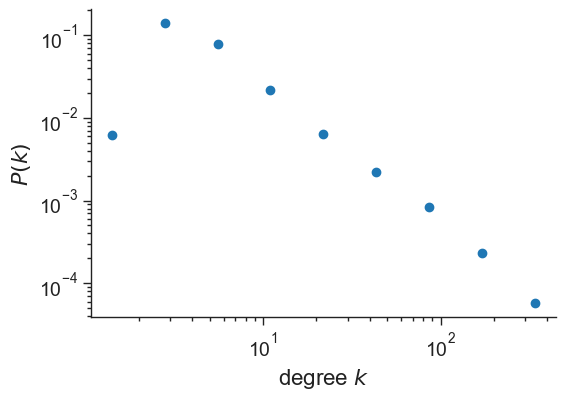

In [9]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.loglog(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')

# Show the plot
plt.show()

Linear Scale Degree Distribution

In [10]:
# Get 20 logarithmically spaced bins between kmin and kmax
bin_edges = np.linspace(kmin, kmax, num=10)

# histogram the data into these bins
density, _ = np.histogram(degrees, bins=bin_edges, density=True)

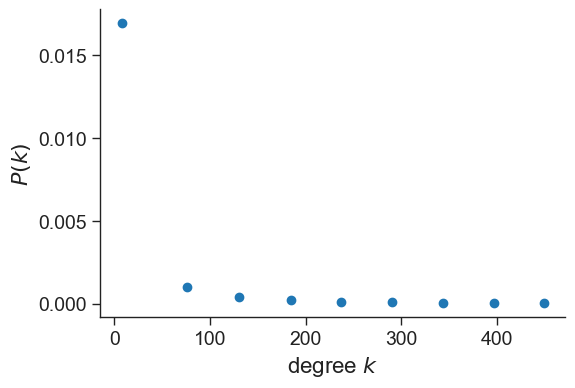

In [11]:
fig = plt.figure(figsize=(6,4))

# "x" should be midpoint (IN LOG SPACE) of each bin
log_be = np.log10(bin_edges)
x = 10**((log_be[1:] + log_be[:-1])/2)

plt.plot(x, density, marker='o', linestyle='none')
plt.xlabel(r"degree $k$", fontsize=16)
plt.ylabel(r"$P(k)$", fontsize=16)

# remove right and top boundaries because they're ugly
ax = plt.gca()
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.yaxis.set_ticks_position('left')
ax.xaxis.set_ticks_position('bottom')


plt.show()

Converting latitiude and longitude into country and continent information using goecoders. Then using that information to calculate statistics for countries and continents

In [12]:
import pycountry
import pycountry_convert as pc
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter
import tqdm
import json
import os

In [13]:
# calculate in-degree and out-degree for each node (airport) in the graph
in_degree_dict = dict(G.in_degree())  
out_degree_dict = dict(G.out_degree()) 


# calculate total degree
total_degree_dict = {node: in_degree + out_degree_dict[node] for node, in_degree in in_degree_dict.items()}

# calculate the highest degree centrality and merge it with latitude, longitude, elevation data.

airports_info = pd.concat([
    df[['source airport', 'lat_src', 'lng_src', 'elevation_src']].rename(columns={
        'source airport': 'Airport',
        'lat_src': 'Latitude',
        'lng_src': 'Longitude',
        'elevation_src': 'Elevation'
    }),
    df[['destination apirport', 'lat_dest', 'lng_dest', 'elevation_dest']].rename(columns={
        'destination apirport': 'Airport',
        'lat_dest': 'Latitude',
        'lng_dest': 'Longitude',
        'elevation_dest': 'Elevation'
    })
]).drop_duplicates('Airport').reset_index(drop=True)


degree_centrality = nx.degree_centrality(G)
centrality_df = pd.DataFrame(degree_centrality.items(), columns=['Airport', 'Centrality']).sort_values(by='Centrality', ascending=False)
final_df = centrality_df.merge(airports_info, on='Airport', how='left')

# add country and continent column data for later.

final_df['Country'] = None
final_df['Continent'] = None

Create 

In [14]:
# creating geo_cache.json
cache_file_path = 'geocode_cache.json'

# check if the cache file exists and load it or initialize an empty cache
if os.path.exists(cache_file_path):
    with open(cache_file_path, 'r') as cache_file:
        geocode_cache = json.load(cache_file)
else:
    geocode_cache = {}



geolocator = Nominatim(user_agent="flight-route-analysis@eric.mao")

# Define a rate-limiter to avoid overloading the geocoding service
geocode = RateLimiter(geolocator.reverse, min_delay_seconds=2)
def get_country_continent(coords):
    # check cache first
    if coords in geocode_cache:
        return geocode_cache[coords].get('country', ''), geocode_cache[coords].get('continent', '')
    
    # if not in cache, perform geocoding
    location = geocode(coords, language='en')
    if location:
        address = location.raw['address']
        country_name = address.get('country', '')
        continent_name = ''
        try:
            country_code = pycountry.countries.lookup(country_name).alpha_2
            continent_code = pc.country_alpha2_to_continent_code(country_code)
            continent_name = pc.convert_continent_code_to_continent_name(continent_code)
        except (LookupError, KeyError):
            print(f"Could not determine continent for {country_name}")
            # if the continent can't be determined proceed with only country name
        
        # update cache with whatever information is available (country and/or continent)
        geocode_cache[coords] = {'country': country_name, 'continent': continent_name}
        
        # dave the updated cache to the file
        with open(cache_file_path, 'w') as cache_file:
            json.dump(geocode_cache, cache_file, indent=4)
        
        return country_name, continent_name
    else:
        # if geocoding fails, return empty strings
        return '', ''



# create a dictionary mapping airport -> country.
for index, row in final_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    coords = f"{latitude}, {longitude}"
    country, continent = get_country_continent(coords)

   



In [15]:
# adjust final_df to include values from geocode_cache dictionary

for index, row in final_df.iterrows():
    latitude = row['Latitude']
    longitude = row['Longitude']
    coords = f"{latitude}, {longitude}"

    if coords in geocode_cache:
        # correctly access the country and continent from the cache
        final_df.at[index, 'Country'] = geocode_cache[coords]['country']
        final_df.at[index, 'Continent'] = geocode_cache[coords]['continent']
    else:
        # Handle cases where coordinates are not in the cache, if necessary
        final_df.at[index, 'Country'] = 'Unknown'
        final_df.at[index, 'Continent'] = 'Unknown'

# ddd in-degree, out-degree, and total degree to final_df
final_df['In_Degree'] = final_df['Airport'].map(in_degree_dict)
final_df['Out_Degree'] = final_df['Airport'].map(out_degree_dict)
final_df['Total_Degree'] = final_df['Airport'].map(total_degree_dict)



# group by 'Country' and sum 'In_Degree' for each country
# sort countries by their total inbound connections in descending order
# do same thing for out_degree
# do same thing for total degree

country_in_degree_sum = final_df.groupby('Country')['In_Degree'].sum().reset_index()
country_in_degree_sorted = country_in_degree_sum.sort_values(by='In_Degree', ascending=False).reset_index(drop=True)

country_out_degree_sum = final_df.groupby('Country')['Out_Degree'].sum().reset_index()
country_out_degree_sorted = country_out_degree_sum.sort_values(by='Out_Degree', ascending=False).reset_index(drop=True)

country_total_degree_sum = final_df.groupby('Country')['Total_Degree'].sum().reset_index()
country_total_degree_sorted = country_total_degree_sum.sort_values(by='Total_Degree', ascending=False).reset_index(drop=True)


# sanity checks

print(country_in_degree_sorted)
print(country_out_degree_sorted)
print(country_total_degree_sorted)


            Country  In_Degree
0     United States       7019
1             China       3422
2            Canada       1636
3    United Kingdom       1541
4           Germany       1403
..              ...        ...
204          Tuvalu          1
205        Eswatini          1
206         Lesotho          1
207          Monaco          1
208            Niue          0

[209 rows x 2 columns]
            Country  Out_Degree
0     United States        7029
1             China        3423
2            Canada        1632
3    United Kingdom        1549
4           Germany        1407
..              ...         ...
204          Tuvalu           1
205        Eswatini           1
206            Niue           1
207          Monaco           1
208         Lesotho           1

[209 rows x 2 columns]
              Country  Total_Degree
0       United States         14048
1               China          6845
2              Canada          3268
3      United Kingdom          3090
4             Ge

         Country  In_Degree
20   Netherlands        345
21        Poland        307
22      Thailand        305
23      Malaysia        295
24      Portugal        293
..           ...        ...
204       Tuvalu          1
205     Eswatini          1
206      Lesotho          1
207       Monaco          1
208         Niue          0

[189 rows x 2 columns]
         Country  Out_Degree
20   Netherlands         346
21        Poland         307
22      Thailand         306
23      Portugal         296
24      Malaysia         296
..           ...         ...
204       Tuvalu           1
205     Eswatini           1
206         Niue           1
207       Monaco           1
208      Lesotho           1

[189 rows x 2 columns]


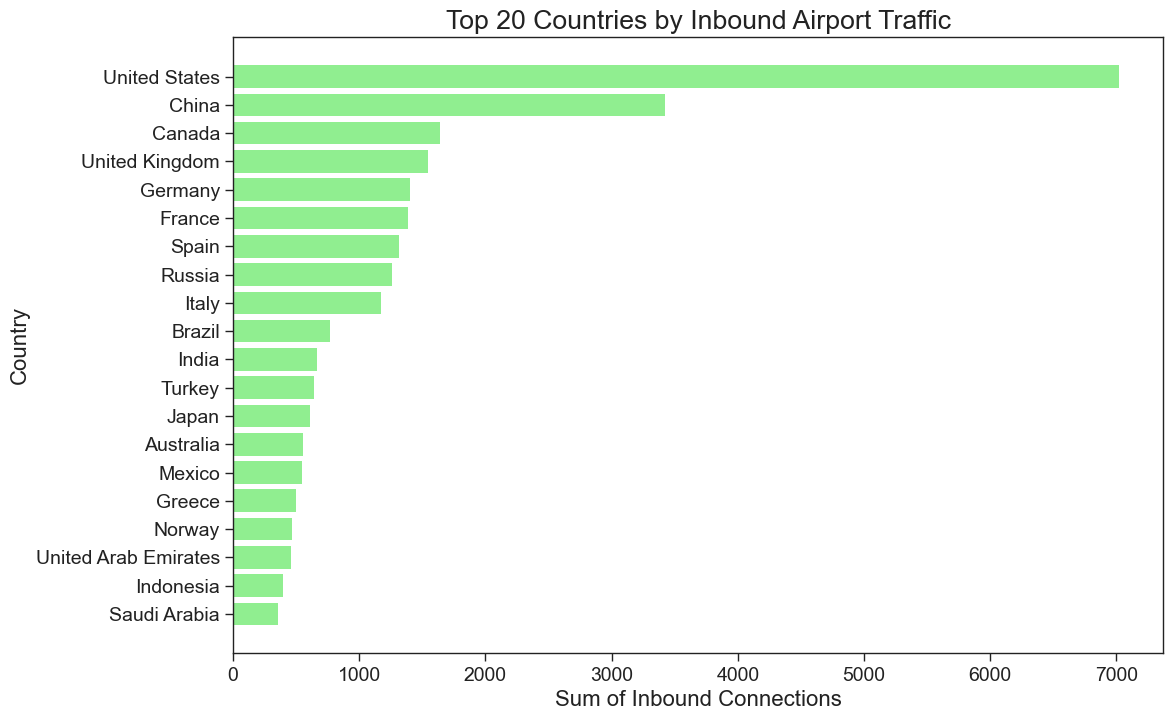

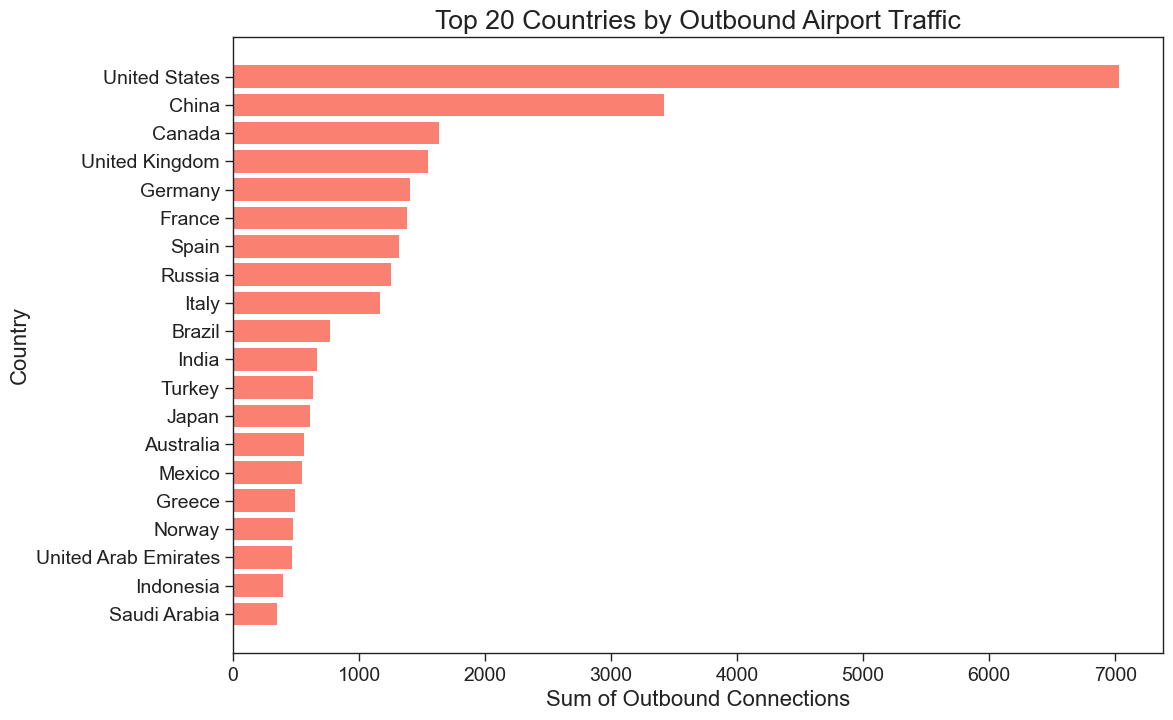

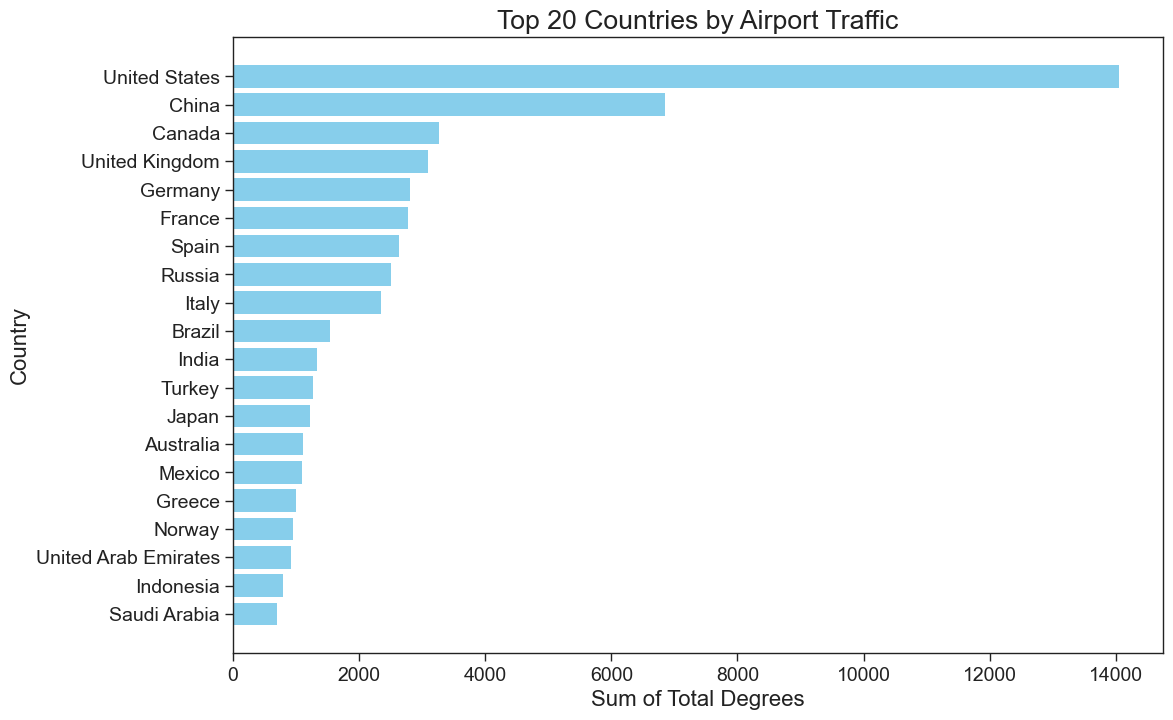

In [16]:
N = 20

# For inbound connections
top_countries_in_degree = country_in_degree_sorted.head(N)
print(country_in_degree_sorted[N:])
print(country_out_degree_sorted[N:])
plt.figure(figsize=(12, 8))  
plt.barh(top_countries_in_degree['Country'], top_countries_in_degree['In_Degree'], color='lightgreen')  
plt.xlabel('Sum of Inbound Connections') 
plt.ylabel('Country')  
plt.title('Top 20 Countries by Inbound Airport Traffic') 
plt.gca().invert_yaxis()  # Invert the y-axis to have the country with the highest inbound connectivity at the top
plt.show()

# for outbound connections
top_countries_out_degree = country_out_degree_sorted.head(N)
plt.figure(figsize=(12, 8))  
plt.barh(top_countries_out_degree['Country'], top_countries_out_degree['Out_Degree'], color='salmon')  
plt.xlabel('Sum of Outbound Connections') 
plt.ylabel('Country')  
plt.title('Top 20 Countries by Outbound Airport Traffic') 
plt.gca().invert_yaxis()  
plt.show()

# for total connections
top_countries_total_degree = country_total_degree_sorted.head(N)
plt.figure(figsize=(12, 8))  
plt.barh(top_countries_total_degree['Country'], top_countries_total_degree['Total_Degree'], color='skyblue')  
plt.xlabel('Sum of Total Degrees') 
plt.ylabel('Country')  
plt.title('Top 20 Countries by Airport Traffic') 
plt.gca().invert_yaxis()  
plt.show()


# for some reason this data is basically almost all the same. prob shouldn't use might be somethin wrong.

In [17]:
# Modify G to contain country and continent data for each node (airport) in case it's needed

for node, attributes in G.nodes(data=True):
    lat = attributes['latitude']
    long = attributes['longitude']
    geographic_data = geocode_cache[f'{lat}, {long}']
    G.nodes[node]['country'] = geographic_data['country']
    G.nodes[node]['continent'] = geographic_data['continent']


nx.write_graphml(G, "network.graphml")


In [18]:
# count the number of times a node shows up with a specific country, then graph how many airports are in each country
# + do the same thing but for continents instead
from collections import defaultdict
numberOfAirportsInCountry = defaultdict(int)
numberOfAirportsInContinent = defaultdict(int)

airport_data_cache_country_path = 'airportCountryDataCache.json'
airport_data_cache_continent_path = 'airportContinentDataCache.json'


for nodes, attributes in G.nodes(data=True):
    country = attributes['country']
    continent = attributes['continent']

    numberOfAirportsInCountry[country] += 1
    numberOfAirportsInContinent[continent] += 1


with open(airport_data_cache_country_path, 'w') as airport_data_country_cache:
            json.dump(numberOfAirportsInCountry, airport_data_country_cache, indent=4)


with open(airport_data_cache_continent_path, 'w') as airport_data_continent_cache:
            json.dump(numberOfAirportsInContinent, airport_data_continent_cache, indent=4)


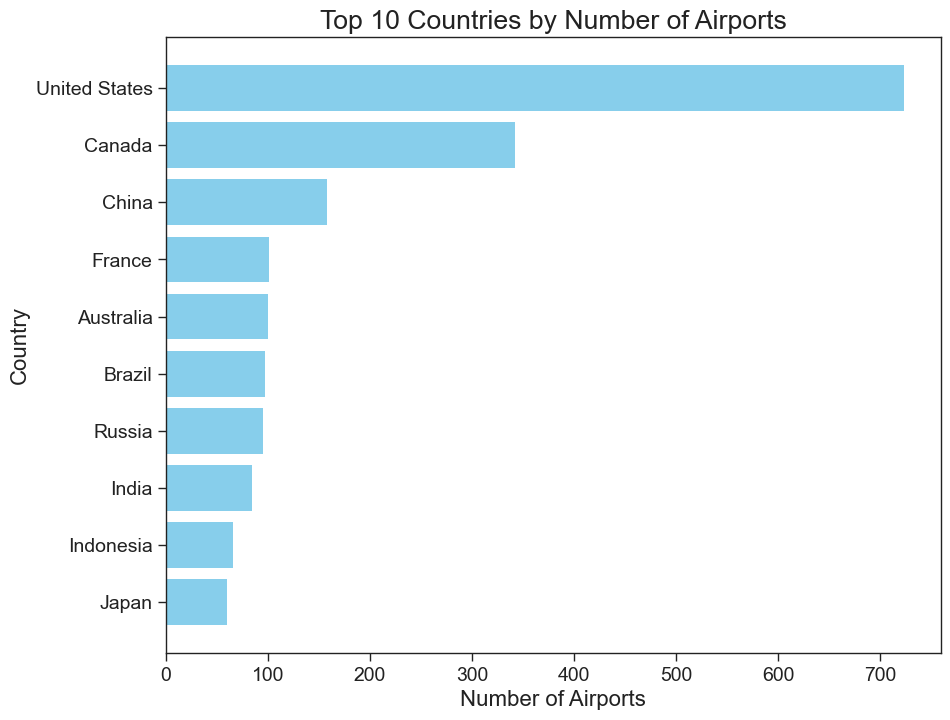

In [19]:
# plot the data on a graph
country_sorted_airports = sorted(numberOfAirportsInCountry.items(), key=lambda a:a[1], reverse=True) # sort in descending order
continent_sorted_airports = sorted(numberOfAirportsInContinent.items(), key=lambda a:a[1], reverse=True) # sort in descending order

top_10_countries = country_sorted_airports[:10]
top_continents = continent_sorted_airports[:]

countries, airports_counts = zip(*top_10_countries)



# create a horizontal bar chart
plt.figure(figsize=(10, 8))
plt.barh(countries, airports_counts, color='skyblue')
plt.xlabel('Number of Airports')
plt.ylabel('Country')
plt.title('Top 10 Countries by Number of Airports')
plt.gca().invert_yaxis()  
plt.show()




In [20]:
# are there patterns of dominance by specific airlines in certain regions or route corridor

# approach
# 0. b/c graph G doesn't contain duplicate edges, use `geo_routes.csv` to extract
# 1. Calculate how many flights were flown by each flight alliance (note source + dest, {alliance: {src_country: # of flights from, src_continent: # of flights from, dest_country:, dest_continent}}) 
# 2. Count the number of times an flight alliance flew to a country or continent




df.loc[:, 'Flight Alliance'] = df['Flight Alliance'].fillna('No Alliance')
flights_by_alliance = df['Flight Alliance'].value_counts()

flights_by_alliance_dict = flights_by_alliance.to_dict()

alliance_flight_json_file_path = 'flights_by_alliance.json'  
alliance_flight_geo_file_path = 'alliance_flight_distribution.json'

with open(alliance_flight_json_file_path, 'w') as json_file:
    json.dump(flights_by_alliance_dict, json_file, indent=4)

df_flights = df


# helper function to get country and continent from latitude and longitude
def get_geo_info(lat, lon):
    coords = f"{lat}, {lon}"
    return geocode_cache[coords]

# Apply the helper function to source and destination lat/lon to get country and continent
df_flights['src_geo'] = df_flights.apply(lambda x: get_geo_info(x['lat_src'], x['lng_src']), axis=1)
df_flights['dest_geo'] = df_flights.apply(lambda x: get_geo_info(x['lat_dest'], x['lng_dest']), axis=1)

# Extract country and continent into separate columns
df_flights['src_country'] = df_flights['src_geo'].apply(lambda x: x['country'])
df_flights['src_continent'] = df_flights['src_geo'].apply(lambda x: x['continent'])
df_flights['dest_country'] = df_flights['dest_geo'].apply(lambda x: x['country'])
df_flights['dest_continent'] = df_flights['dest_geo'].apply(lambda x: x['continent'])

# Group by flight alliance and calculate counts
flights_alliance_summary = df_flights.groupby('Flight Alliance').apply(
    lambda x: {
        'src_country': x['src_country'].value_counts().to_dict(),
        'src_continent': x['src_continent'].value_counts().to_dict(),
        'dest_country': x['dest_country'].value_counts().to_dict(),
        'dest_continent': x['dest_continent'].value_counts().to_dict()
    }
).to_dict()

with open(alliance_flight_geo_file_path, 'w') as json_file2:
    json.dump(flights_alliance_summary, json_file2, indent=4)

#  sanity check
flights_alliance_summary




/var/folders/lf/dr6s6bmx50dcvy0zh98t8hg00000gn/T/ipykernel_11643/2845776534.py:50: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  flights_alliance_summary = df_flights.groupby('Flight Alliance').apply(


{'No Value': {'src_country': {'United States': 5379,
   'China': 4510,
   'United Kingdom': 1952,
   'Spain': 1648,
   'Canada': 1643,
   'Germany': 1480,
   'India': 1455,
   'France': 1379,
   'Italy': 1208,
   'Russia': 1172,
   'Brazil': 938,
   'Indonesia': 777,
   'United Arab Emirates': 690,
   'Australia': 651,
   'Japan': 600,
   'Greece': 563,
   'Mexico': 544,
   'Turkey': 536,
   'Malaysia': 512,
   'Saudi Arabia': 482,
   'Norway': 466,
   'Iran': 414,
   'Thailand': 383,
   'Philippines': 354,
   'Portugal': 331,
   'Netherlands': 277,
   'Pakistan': 267,
   'Sweden': 261,
   'Ireland': 250,
   'Poland': 247,
   'Colombia': 244,
   'Singapore': 241,
   'Taiwan': 232,
   'Morocco': 220,
   'Belgium': 212,
   'Algeria': 198,
   'Switzerland': 191,
   'Argentina': 190,
   'Tunisia': 180,
   'Kazakhstan': 178,
   'Austria': 177,
   'Egypt': 175,
   'South Korea': 160,
   'Ukraine': 159,
   'Venezuela': 152,
   'Qatar': 147,
   'Denmark': 139,
   'Papua New Guinea': 135,
   'S

/var/folders/lf/dr6s6bmx50dcvy0zh98t8hg00000gn/T/ipykernel_11643/4069098431.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


{'Sudan', 'Syria', 'Cyprus', 'Italy', 'Malaysia', 'N. Cyprus', 'Ukraine', 'Bulgaria', 'North Macedonia', 'Sri Lanka', 'Indonesia', 'China', 'Dem. Rep. Congo', 'Falkland Is.', 'Tajikistan', 'Guatemala', 'Chad', 'Taiwan', 'Rwanda', 'Trinidad and Tobago', 'Dominican Rep.', 'Brazil', 'Honduras', 'Azerbaijan', 'Bangladesh', 'Libya', 'Thailand', 'Kenya', 'Laos', 'Fr. S. Antarctic Lands', 'Yemen', 'Mongolia', 'New Caledonia', 'Ireland', 'Eq. Guinea', 'Eritrea', 'Vanuatu', 'Angola', 'Uganda', 'Slovenia', 'Finland', 'Timor-Leste', 'France', 'Bolivia', 'Hungary', 'Iraq', 'Colombia', 'Jamaica', 'Mexico', 'Tunisia', 'Lebanon', 'South Africa', 'Venezuela', 'Morocco', 'Portugal', 'Nepal', 'Belgium', 'Bahamas', 'Guinea', 'Austria', 'Belize', 'Mauritania', 'Algeria', 'Iran', 'Lithuania', 'Cameroon', 'Jordan', 'North Korea', 'Malawi', 'Turkmenistan', 'Djibouti', 'Namibia', 'Uzbekistan', 'Liberia', 'Paraguay', 'Lesotho', 'Philippines', 'Congo', 'Oman', 'Afghanistan', 'Canada', 'eSwatini', 'Palestine', '

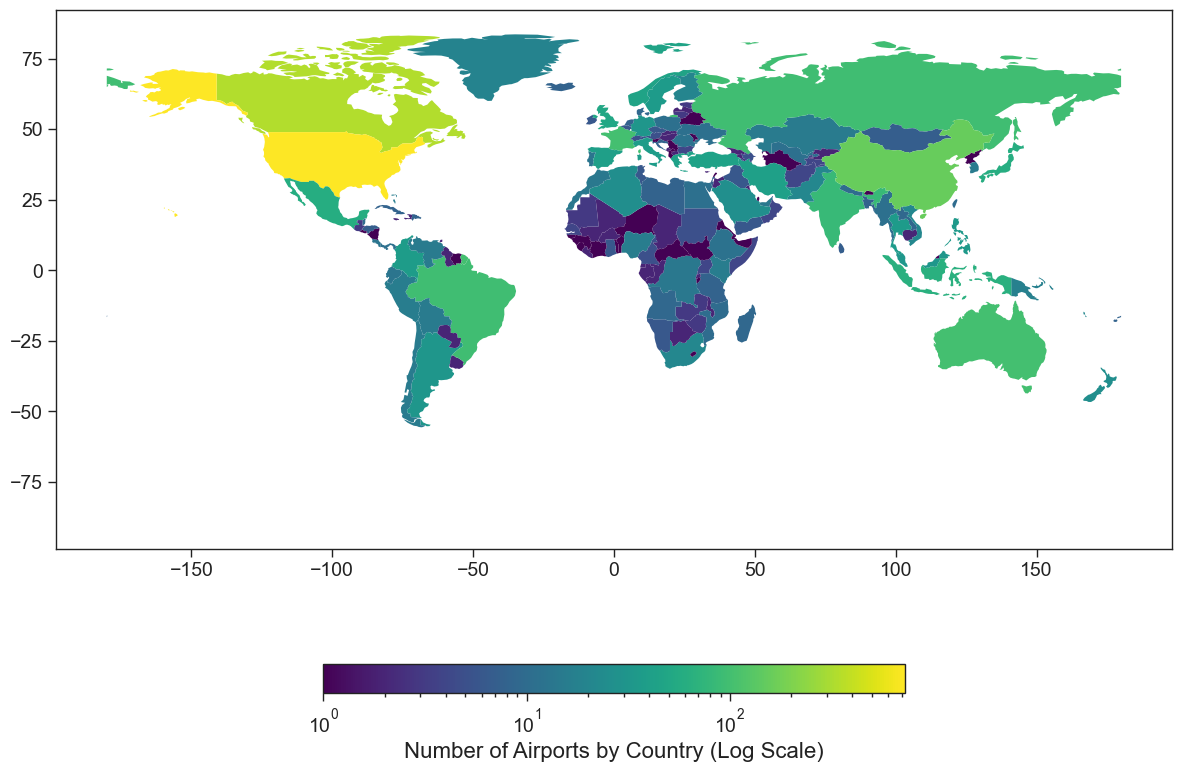

In [21]:


# Load world shape map
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))






geo_country_names = set(world['name'])
json_country_names = set(numberOfAirportsInCountry.keys())
print(geo_country_names)
# find names in JSON data that don't have an exact match in the GeoDataFrame
unmatched_names = json_country_names - geo_country_names

print(f"Unmatched Country Names: {unmatched_names}")
numAirportsModified = numberOfAirportsInCountry.copy()
# manually fix some naming inconsistencies

numAirportsModified['United States of America'] = numAirportsModified['United States']
numAirportsModified['Dem. Rep. Congo'] = numAirportsModified['Democratic Republic of the Congo']
numAirportsModified['Central African Rep.'] = numAirportsModified['Central African Republic']
numAirportsModified['Eq. Guinea'] = numAirportsModified['Equatorial Guinea']
numAirportsModified['Dominican Rep.'] = numAirportsModified['Dominican Republic']
numAirportsModified['S. Sudan'] = numAirportsModified['South Sudan']
numAirportsModified['Congo'] = numAirportsModified['Congo-Brazzaville']

world['number_of_airports'] = world['name'].map(numAirportsModified).fillna(0)




vmin, vmax = world['number_of_airports'].replace(0, pd.NA).dropna().min(), world['number_of_airports'].max()

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

# Plot the world map with the number of airports per country
world.plot(column='number_of_airports', ax=ax, legend=True,
           norm=LogNorm(vmin=vmin, vmax=vmax),
           cmap='viridis',
           legend_kwds={'label': "Number of Airports by Country (Log Scale)",
                        'shrink': 0.5,
                        'orientation': "horizontal"},)

# Show the plot
plt.show()


In [22]:
# modify alliance_flight_distribution to have geopy names
# fixes some data inconsistencies with some countries not having values.
# i don't remember if this works. for safety, just leave this in.

with open(alliance_flight_geo_file_path, 'r') as file:
    flights_alliance_summary = json.load(file)

# define a dictionary for the name changes
name_changes = {
    'United States':'United States of America' ,
     'Democratic Republic of the Congo':'Dem. Rep. Congo',
    'Central African Republic': 'Central African Rep.',
    'Equatorial Guinea': 'Eq. Guinea', 
    'Dominican Republic': 'Dominican Rep.',
    'South Sudan' :'S. Sudan',
    'Congo-Brazzaville': 'Congo',
}

# apply the name changes to the summary data
for alliance, data in flights_alliance_summary.items():
    for src_dest in ['src_country', 'dest_country']:
        for old_name, new_name in name_changes.items():
            if old_name in data[src_dest]:
                data[src_dest][new_name] = data[src_dest].get(new_name, 0) + data[src_dest][old_name]


# find all unique countries mentioned across all alliances
# ensure each country exists in each alliance's src_country and dest_country, set to 0 if not present
unique_countries = set()
for alliance_data in flights_alliance_summary.values():
    unique_countries.update(alliance_data['src_country'].keys())
    unique_countries.update(alliance_data['dest_country'].keys())


for alliance, data in flights_alliance_summary.items():
    for country in unique_countries:
        data['src_country'].setdefault(country, 0)
        data['dest_country'].setdefault(country, 0)


with open(alliance_flight_geo_file_path, 'w') as file:
    json.dump(flights_alliance_summary, file, indent=4)


/var/folders/lf/dr6s6bmx50dcvy0zh98t8hg00000gn/T/ipykernel_11643/2929345242.py:4: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


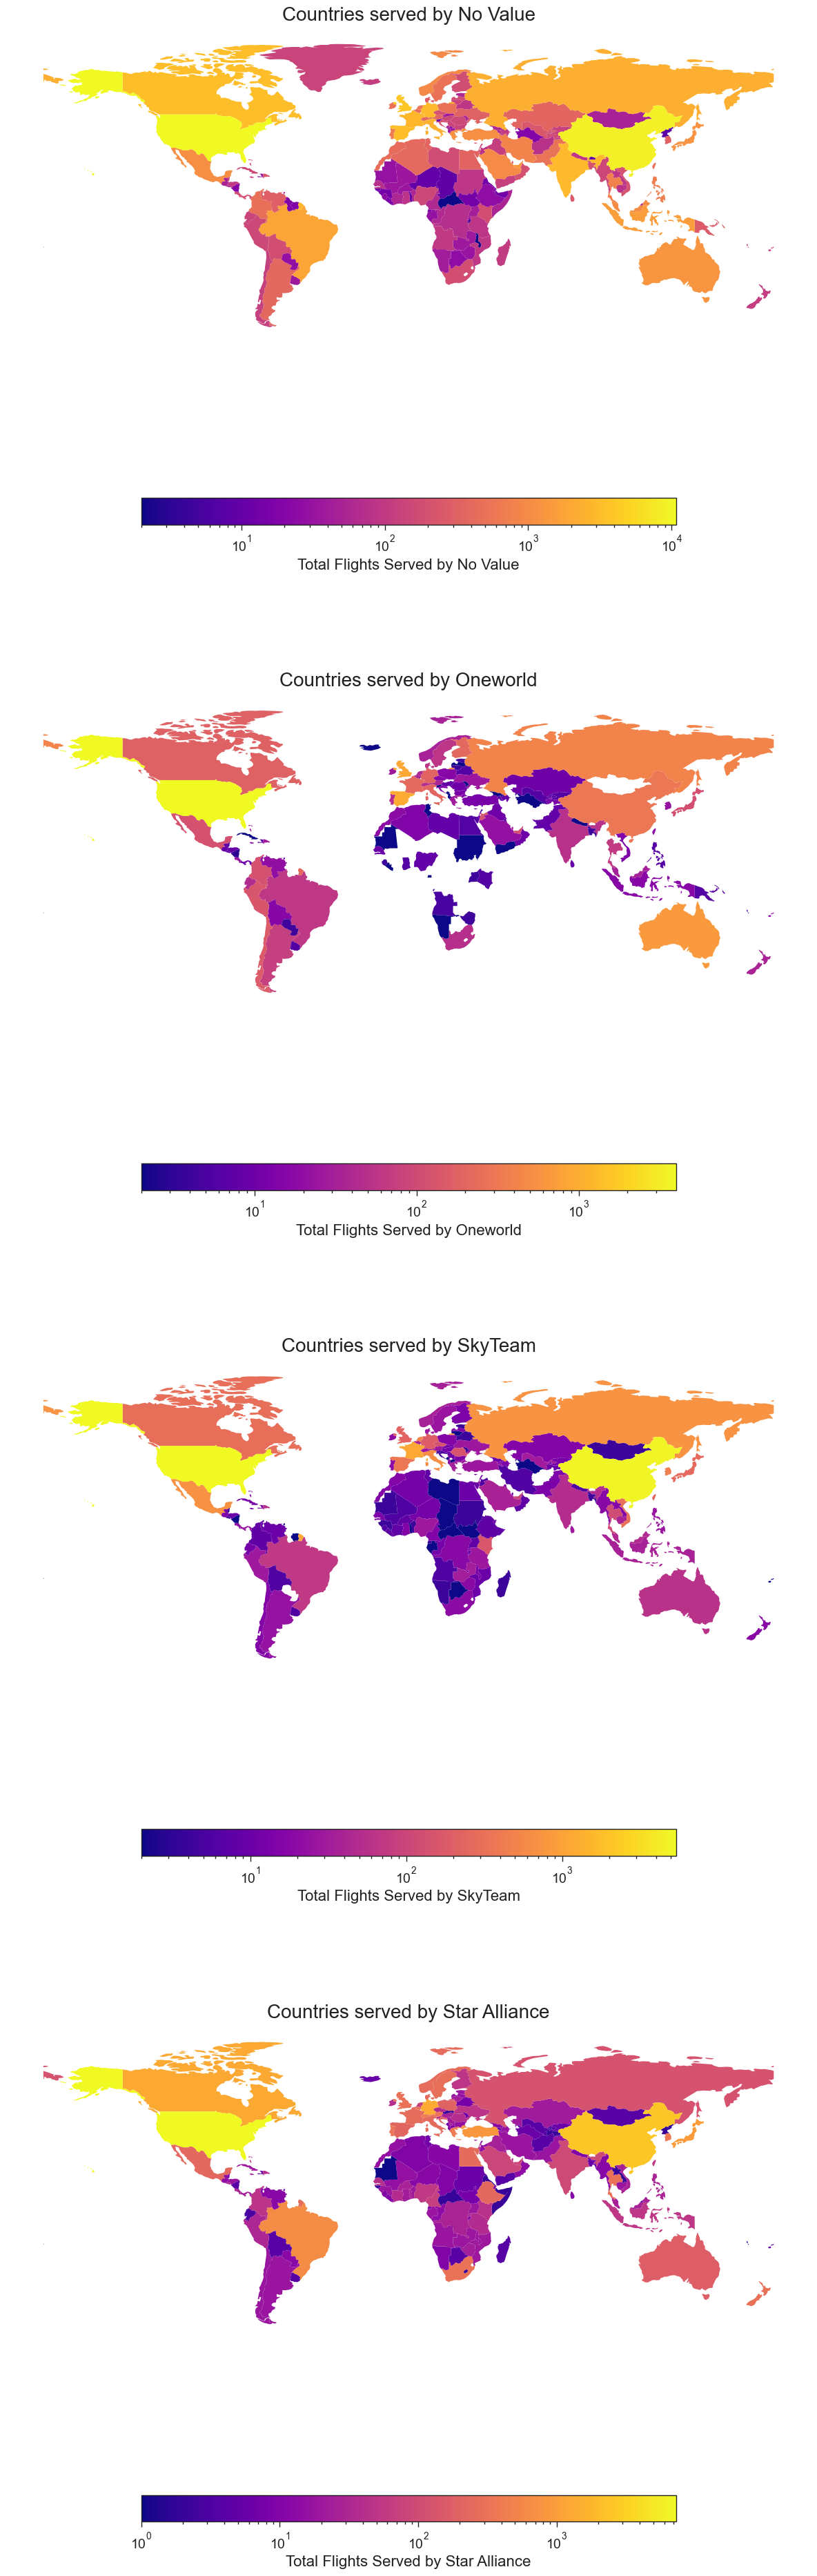

In [23]:
# "countries served" = # of times alliance has flown from country + # of times alliance has flown to country



world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


alliance_flight_geo_file_path = 'alliance_flight_distribution.json'

with open(alliance_flight_geo_file_path, 'r') as file:
    flights_alliance_summary = json.load(file)


alliances = flights_alliance_summary.keys()
n_alliances = len(flights_alliance_summary)


fig, axes = plt.subplots(n_alliances, 1, figsize=(20, n_alliances * 12))



def calculate_total_flights(alliance_data, column_prefix):
    total_flights = {}
    for country, num_flights in alliance_data[column_prefix].items():
        total_flights[country] = num_flights
    return total_flights

# plot a choropleth map for each alliance
for idx, (alliance, ax) in enumerate(zip(alliances, axes.flatten())):

    total_flights_from = calculate_total_flights(flights_alliance_summary[alliance], 'src_country')
    total_flights_to = calculate_total_flights(flights_alliance_summary[alliance], 'dest_country')
    total_flights = {country: total_flights_from.get(country, 0) + total_flights_to.get(country, 0)
                     for country in set(total_flights_from) | set(total_flights_to)}
    world['total_flights'] = world['name'].apply(lambda x: total_flights.get(x, 0))
    
    # set up the normalization for the color scale
    vmin = world['total_flights'].replace(0, pd.NA).dropna().min()
    vmax = world['total_flights'].max()
    
    # plot the world map for each alliance
    world.plot(column='total_flights', ax=ax, legend=True,
               norm=LogNorm(vmin=vmin, vmax=vmax), cmap='plasma',
               legend_kwds={'label': f"Total Flights Served by {alliance}",
                            'shrink': 0.5,
                            'orientation': "horizontal"})
    
    ax.set_title(f"Countries served by {alliance}", fontdict={'fontsize': 20})
    

    ax.set_axis_off()

plt.show()
fig.savefig('alliance_map_country.png')

/var/folders/lf/dr6s6bmx50dcvy0zh98t8hg00000gn/T/ipykernel_11643/1768780827.py:1: FutureWarning: The geopandas.dataset module is deprecated and will be removed in GeoPandas 1.0. You can get the original 'naturalearth_lowres' data from https://www.naturalearthdata.com/downloads/110m-cultural-vectors/.
  world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))


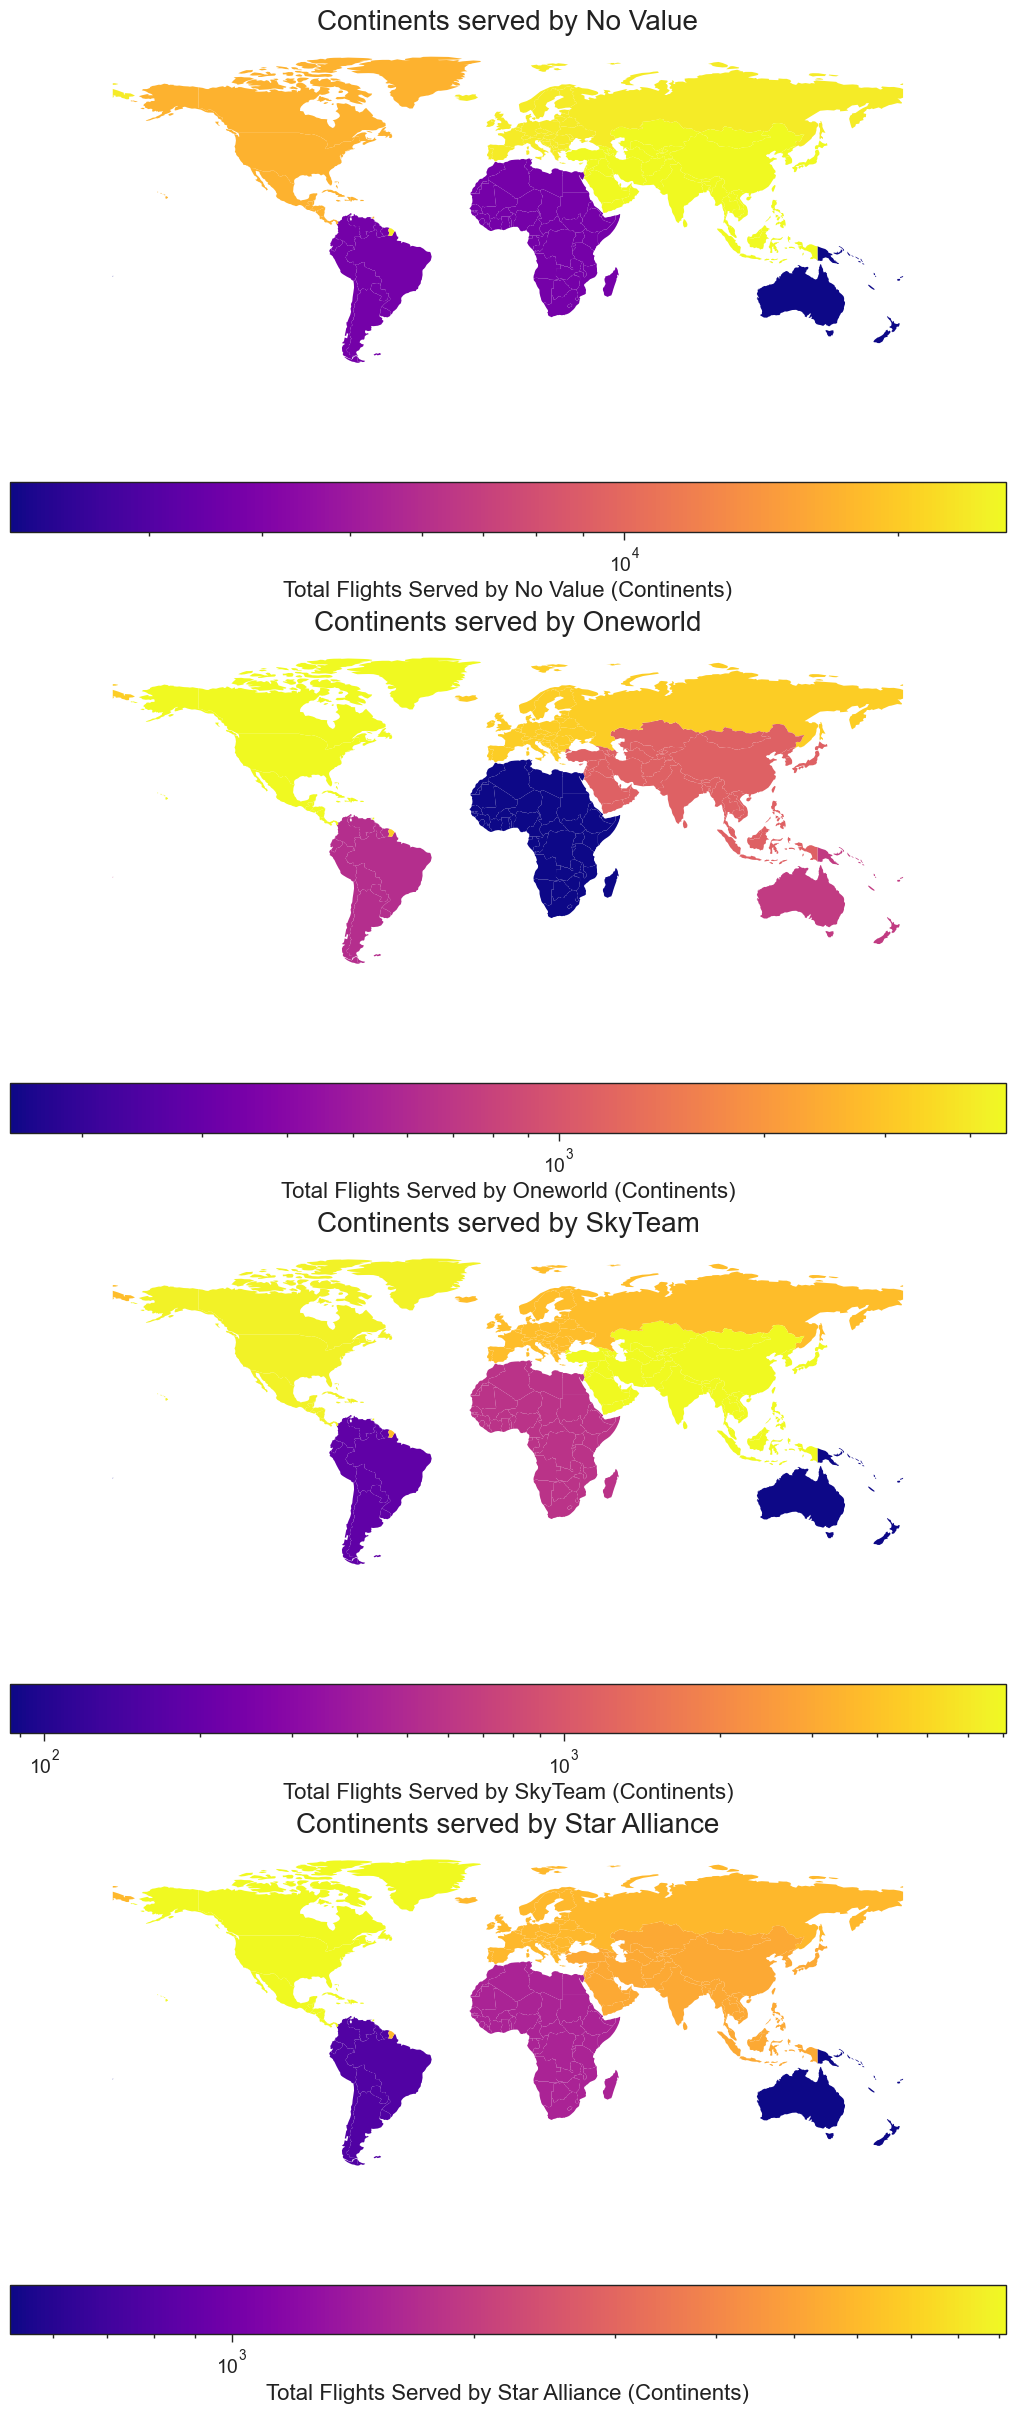

In [24]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
alliance_flight_geo_file_path = 'alliance_flight_distribution.json'  # Update with correct path
with open(alliance_flight_geo_file_path, 'r') as file:
    flights_alliance_summary = json.load(file)


alliances = list(flights_alliance_summary.keys())
n_alliances = len(alliances)


fig, axes = plt.subplots(n_alliances, 1, figsize=(20, n_alliances * 6), constrained_layout=True)

# Function to calculate total flights for each continent
def calculate_total_flights_by_continent(alliance_data, column_prefix):
    total_flights = {}
    for continent, num_flights in alliance_data[column_prefix].items():
        total_flights[continent] = num_flights
    return total_flights


for idx, (alliance, ax) in enumerate(zip(alliances, axes.flatten())):
    total_flights_from = calculate_total_flights_by_continent(flights_alliance_summary[alliance], 'src_continent')
    total_flights_to = calculate_total_flights_by_continent(flights_alliance_summary[alliance], 'dest_continent')
    total_flights = {continent: total_flights_from.get(continent, 0) + total_flights_to.get(continent, 0)
                     for continent in set(total_flights_from) | set(total_flights_to)}
    
    # aggregate the 'world' geodataframe by continents
    world['continent_total_flights'] = world['continent'].apply(lambda x: total_flights.get(x, 0))
    
    # normalization for the color scale
    vmin, vmax = min(total_flights.values()), max(total_flights.values())
    

    world.plot(column='continent_total_flights', ax=ax, legend=True,
               norm=LogNorm(vmin=vmin if vmin > 0 else 1, vmax=vmax), cmap='plasma',
               legend_kwds={'label': f"Total Flights Served by {alliance} (Continents)",
                            'shrink': 0.5,
                            'orientation': "horizontal"})
    
    ax.set_title(f"Continents served by {alliance}", fontdict={'fontsize': 20})
    ax.set_axis_off()

plt.show()
fig.savefig('alliance_map_continent.png')

In [25]:
# calculate betweeness centrality and plot it on the world map. Add elevation, latitude, longtiude

betweenness_centrality = nx.betweenness_centrality(G)

# turn the betweenness centrality to a DataFrame
centrality_df = pd.DataFrame(list(betweenness_centrality.items()), columns=['Airport', 'Betweenness']).sort_values(by='Betweenness', ascending=False)

final_df = centrality_df.merge(airports_info, on='Airport', how='left')

# Get the top 10 airports with the highest betweenness centrality
top_10_airports = final_df.head(10)

print(top_10_airports)

  Airport  Betweenness   Latitude   Longitude   Elevation
0     ANC     0.070204  61.177134 -149.990686   27.538055
1     LAX     0.066164  33.942153 -118.403605   35.619091
2     CDG     0.061703  49.007860    2.550772  104.570091
3     DXB     0.059350  25.248141   55.353662    0.959111
4     FRA     0.051000  50.038019    8.562158  101.215523
5     PEK     0.049167  40.079857  116.603112   32.507244
6     ORD     0.047430  41.980241  -87.908985  198.971497
7     SEA     0.045268  47.448394 -122.308613  120.563141
8     AMS     0.042658  52.308806    4.758532   -2.792660
9     YYZ     0.042527  43.677141  -79.633367  168.606415


In [26]:


world_map = folium.Map(location=[20, 0], zoom_start=2)

def altitude_color(elevation):
    if elevation > 5000:
        return 'maroon'  # extreme high elevations
    elif elevation > 4000:
        return 'darkred'
    elif elevation > 3000:
        return 'red'
    elif elevation > 2000:
        return 'orange'
    elif elevation > 1000:
        return 'lightorange'
    elif elevation > 500:
        return 'gold'
    elif elevation > 250:
        return 'yellow'
    elif elevation > 100:
        return 'lightgreen'
    else:
        return 'green'  # low elevations


for index, row in top_10_airports.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"{row['Airport']}: Betweenness - {row['Betweenness']}, Elevation - {row['Elevation']}m",
        icon=folium.Icon(color=altitude_color(row['Elevation']), icon='info-sign')
    ).add_to(world_map)

world_map

In [27]:
# Plotting degree centrality chloropleth map

# COPY PASTING CODE FROM BEFORE TO GET DEGREE CENTRALITY + COORDINATE METADATA
in_degree_dict = dict(G.in_degree())  
out_degree_dict = dict(G.out_degree())  

total_degree_dict = {node: in_degree + out_degree_dict[node] for node, in_degree in in_degree_dict.items()}

airports_info = pd.concat([
    df[['source airport', 'lat_src', 'lng_src', 'elevation_src']].rename(columns={
        'source airport': 'Airport',
        'lat_src': 'Latitude',
        'lng_src': 'Longitude',
        'elevation_src': 'Elevation'
    }),
    df[['destination apirport', 'lat_dest', 'lng_dest', 'elevation_dest']].rename(columns={  # Corrected spelling here
        'destination apirport': 'Airport',
        'lat_dest': 'Latitude',
        'lng_dest': 'Longitude',
        'elevation_dest': 'Elevation'
    })
]).drop_duplicates('Airport').reset_index(drop=True)


degree_centrality = nx.degree_centrality(G)
degree_centrality_df = pd.DataFrame(degree_centrality.items(), columns=['Airport', 'Centrality'])


degree_centrality_df = degree_centrality_df.merge(airports_info, on='Airport', how='left').sort_values(by='Centrality', ascending=False)

# print for sanity check
print(degree_centrality_df.head())  

world_map = folium.Map(location=[20, 0], zoom_start=2)

# define a function to determine marker color based on degree centrality. NOT USED
def centrality_color(centrality):
    if centrality > 0.1:  # Adjust thresholds as needed
        return 'darkred'
    elif centrality > 0.05:
        return 'red'
    elif centrality > 0.01:
        return 'orange'
    else:
        return 'green'


top_10_degree_airports = degree_centrality_df.head(10)


for index, row in top_10_degree_airports.iterrows():
    folium.Marker(
        location=[row['Latitude'], row['Longitude']],
        popup=f"Airport: {row['Airport']}, Centrality: {row['Centrality']:.4f}, Elevation: {row['Elevation']}m",
        icon=folium.Icon(color=altitude_color(row['Elevation']), icon='info-sign')
    ).add_to(world_map)

world_map

    Airport  Centrality   Latitude  Longitude   Elevation
502     FRA    0.139311  50.038019   8.562158  101.215523
449     CDG    0.137266  49.007860   2.550772  104.570091
227     AMS    0.135222  52.308806   4.758532   -2.792660
797     IST    0.133470  41.260748  28.742428   85.901001
202     ATL    0.126460  33.636163 -84.429375  304.858063


/var/folders/lf/dr6s6bmx50dcvy0zh98t8hg00000gn/T/ipykernel_11643/2912467262.py:55: UserWarning: color argument of Icon should be one of: {'red', 'lightgreen', 'darkgreen', 'black', 'blue', 'darkblue', 'purple', 'lightblue', 'darkred', 'white', 'lightred', 'pink', 'beige', 'darkpurple', 'orange', 'green', 'cadetblue', 'gray', 'lightgray'}.
  icon=folium.Icon(color=altitude_color(row['Elevation']), icon='info-sign')
